# Image postprocessing of Refrigerant sprays

This program takes images of Refrigerant sprays and obtains extinction profiles.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 15/02/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia



In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import scipy.integrate, scipy.signal
from joblib import Parallel, delayed
%matplotlib notebook

In [2]:
# Define where images come from.
srcdir = "/mnt/rds-pharma-sprays/ExperimentData/2022_02_RefrigerantSpray/nz013/"
source_images =           srcdir+"nz013_r134a_03.raw"
source_bkgnd  = glob.glob(srcdir+"nz013_r134a_03b*.raw")[-1]
SPATIAL_RES = 0.7493 # pixel per micron
FRAME_RATE = 1069. # frames/s

In [14]:
# Read in images.
B=ImageSequence(source_bkgnd,rawtype='chronos14_mono_12bit',width=1280,height=1024,frames=(2,10))
print("")
I=ImageSequence(source_images,rawtype='chronos14_mono_12bit',width=1280,height=1024, IO_threads=1, frames=(0,1000))

Reading /mnt/rds-pharma-sprays/ExperimentData/2022_02_RefrigerantSpray/nz013/nz013_r134a_03bk.raw
Chronos 12-bit RAW
File contains 11 frames (1280 x 1024)
Reading frames 2 to 10
Read 15.0 MiB in 0.2 sec
	Data in memory:	 (8, 1024, 1280)
	Intensity range:	 0 to 385 	 uint16
	Array size:	20.0 MB

Reading /mnt/rds-pharma-sprays/ExperimentData/2022_02_RefrigerantSpray/nz013/nz013_r134a_03.raw
Chronos 12-bit RAW
File contains 8733 frames (1280 x 1024)
Reading frames 0 to 1000
Read 1875.0 MiB in 18.7 sec
	Data in memory:	 (1000, 1024, 1280)
	Intensity range:	 0 to 421 	 uint16
	Array size:	2500.0 MB


In [4]:
# apply crop
B.crop(0,1024,30,1280)
I.crop(0,1024,30,1280)
print('\nFinal array sizes:', B.shape(), I.shape())

# Mask unwanted portions of image
#B.mask_box(268,305,903,916)
#B.mask_box(0,42,903,916)

# apply flip
#B.fliph()
#I.fliph()


Final array sizes: (11, 1024, 1250) (7421, 1024, 1250)


In [15]:
# Remove background, put into array Ib
Ib = np.zeros_like(I.arr,dtype=np.float32)
bkgnd = np.nanmean(B.arr.astype(np.float32),axis=0)
bkgnd[bkgnd<=0] = np.nan
for n in range(I.N):
    Ib[n,...] = I.arr[n,...] / bkgnd
    
# Clip value range
Ib[Ib<-0.5]=-0.5
Ib[Ib>1.5]=1.5
    
# Convert transmission to extinction
Ib = 1.0 - Ib

# Get co-ordinates
y = np.arange(Ib.shape[1])
x = np.arange(Ib.shape[2])
t = np.arange(Ib.shape[0])

<IPython.core.display.Javascript object>


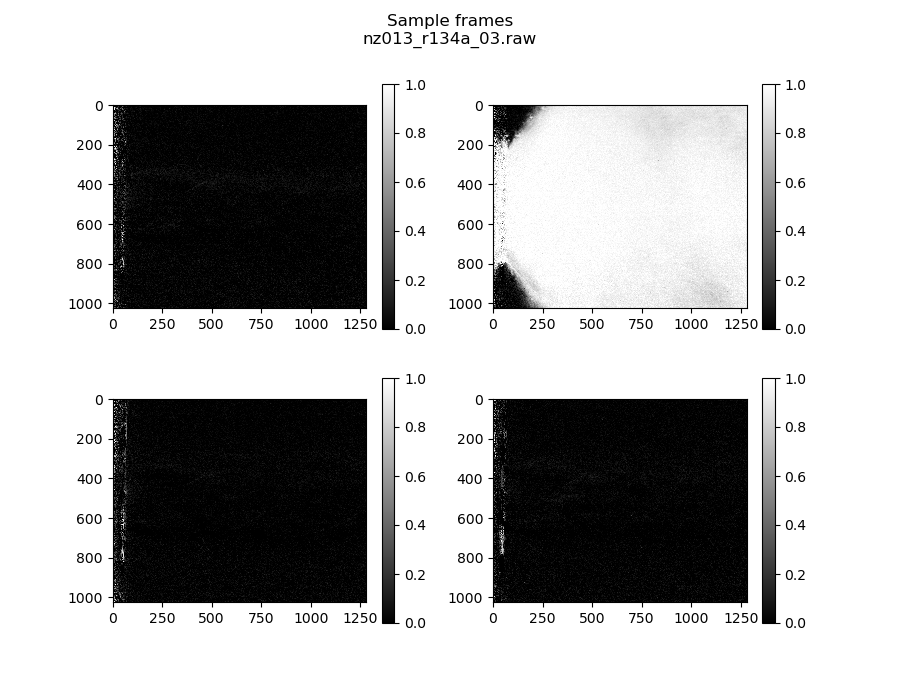

In [16]:
plt.rcParams["figure.figsize"] = (9, 7)

# Find good times to plot where stuff is happening
sumIntensities = np.sum(np.sum(Ib,axis=-1),axis=-1)
i1 = np.where(sumIntensities[1:-2]==np.nanmax(sumIntensities[1:-2]))[0][0] + 1
i2 = int(I.N/2)

# Show some samples
fig=plt.figure()
plt.suptitle("Sample frames\n"+os.path.basename(source_images))
ax=fig.add_subplot(221)
h=ax.imshow(Ib[1,...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h)
ax=fig.add_subplot(222)
h=ax.imshow(Ib[i1,...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);
ax=fig.add_subplot(223)
h=ax.imshow(Ib[i2,...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);
ax=fig.add_subplot(224)
h=ax.imshow(Ib[I.N-1,...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);

## Classify sprays based on extinction near nozzle

In [7]:
# Reslice near the nozzle to see time evolution
# Average over several X positions.
near_nozzle_profiles = np.nanmean(Ib[...,25:50],axis=-1).T
near_nozzle_integral = scipy.integrate.simps(near_nozzle_profiles.T,x=y,axis=-1)
near_nozzle_integral[0]=np.nan

# Use the integral to find the time where the spray extinction is high.
threshold = 0.5 # higher value means less time samples but lower std dev.
on = np.nan_to_num(near_nozzle_integral) > threshold*np.nanmax(near_nozzle_integral)

# Smooth the 'on' threshold so that each region must be >= 50 frames in duration.
j=0
for i in range(1,len(on)):
    if on[i-1]==on[i]: j+=1
    elif j<=50:
        j+=1
        on[i]=on[i-1]
    else:
        j=0
        
# Transitional region +-30 frames either side of mode transition.
don = np.hstack((0,np.diff(on)))
trans = np.abs(don)
for i in range(30,len(don)-30):
    if don[i]!=0:
        trans[i-15:i+15]=1

In [8]:
# Show the time evolution near the nozzle
plt.rcParams["figure.figsize"] = (9, 7)
fig=plt.figure()
plt.suptitle(os.path.basename(source_images))
ax=fig.add_subplot(211)
plt.title("Time evolution near nozzle")
plt.ylabel("Y [pixel]")
plt.xlabel("Time [frame#]")
h=ax.imshow(near_nozzle_profiles, cmap=plt.cm.gnuplot,vmin=0)
plt.colorbar(h)
ax=fig.add_subplot(212)
ax.plot(t, near_nozzle_integral, lw=1)
plt.ylabel("Transverse integral")
plt.xlabel("Time [frame#]");
ax.fill_between(t,0*on,np.nanmax(near_nozzle_integral)*on,lw=0,alpha=.2,color='g')
ax.fill_between(t,0*trans,np.nanmax(near_nozzle_integral)*trans,lw=0,alpha=.2,color='r');

<IPython.core.display.Javascript object>

In [9]:
image_filename=srcdir+'postprocessed_timeEvol_'+os.path.basename(source_images)+".pdf"
print(image_filename)
plt.savefig(image_filename)

/mnt/rds-pharma-sprays/ExperimentData/2022_02_RefrigerantSpray/nzM6/postprocessed_timeEvol_nzM6_r134a_01.raw.pdf


## Steady state statistics

In [10]:
# Take mean & std dev over all the data
Im0 = np.nanmean(Ib,axis=0)
Is0 = np.nanstd(Ib,axis=0)

In [11]:
# Take mean & std dev over liquid-only period
Im1 = np.nanmean(Ib[on,...],axis=0)
Is1 = np.nanstd(Ib[on,...],axis=0)

In [12]:
# Take mean & std dev over vapour-dominated period
Im2 = np.nanmean(Ib[~on,...],axis=0)
Is2 = np.nanstd(Ib[~on,...],axis=0)

In [13]:
# Take mean & std dev over transitory period
Im3 = np.nanmean(Ib[trans,...],axis=0)
Is3 = np.nanstd(Ib[trans,...],axis=0)

In [14]:
# Plot mean and std dev profiles

plt.rcParams["figure.figsize"] = (10, 10)
cmap=plt.cm.jet

fig=plt.figure()
ax=fig.add_subplot(421)
plt.suptitle(os.path.basename(source_images))
plt.title("Mean - all data")
h=ax.imshow(Im0,cmap=cmap,vmin=0,vmax=1)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(422)
plt.title("Std. Dev. - all data")
h=ax.imshow(Is0,cmap=cmap,vmin=0,vmax=.45)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(423)
plt.suptitle(os.path.basename(source_images))
plt.title("Mean - liquid dominated flow")
h=ax.imshow(Im1,cmap=cmap,vmin=0,vmax=1)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(424)
plt.title("Std. Dev. - liquid dominated flow")
h=ax.imshow(Is1,cmap=cmap,vmin=0,vmax=.45)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(425)
plt.suptitle(os.path.basename(source_images))
plt.title("Mean - Vapour dominated flow")
h=ax.imshow(Im2,cmap=cmap,vmin=0,vmax=.75)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(426)
plt.title("Std. Dev. - Vapour dominated flow")
h=ax.imshow(Is2,cmap=cmap,vmin=0,vmax=.45)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(427)
plt.suptitle(os.path.basename(source_images))
plt.title("Mean - Transitional flow")
h=ax.imshow(Im3,cmap=cmap,vmin=0,vmax=.75)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(428)
plt.title("Std. Dev. - Transitional flow")
h=ax.imshow(Is3,cmap=cmap,vmin=0,vmax=.45)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

fig.subplots_adjust(hspace=.5,wspace=0,left=.05,right=.95,bottom=.05,top=.92);

<IPython.core.display.Javascript object>

In [15]:
image_filename=srcdir+'postprocessed_meanstd_'+os.path.basename(source_images)+".pdf"
print(image_filename)
plt.savefig(image_filename)

/mnt/rds-pharma-sprays/ExperimentData/2022_02_RefrigerantSpray/nzM6/postprocessed_meanstd_nzM6_r134a_01.raw.pdf


In [16]:
# Save post processed data to HDF5 file
import h5py
output_filename=srcdir+'postprocessed_'+os.path.basename(source_images)+".h5"

H=h5py.File(output_filename,'w') # over-write existing.

H.attrs['SPATIAL_RES']=SPATIAL_RES
H.attrs['FRAME_RATE']=FRAME_RATE

G=H.create_group('temporal_evolution')
G.create_dataset('near_nozzle_integral',data=near_nozzle_integral,compression='gzip')
G.create_dataset('time',data=t,compression='gzip')
G.create_dataset('liquid_dominated',data=on,compression='gzip')
G.create_dataset('transitional',data=trans,compression='gzip')

G=H.create_group('mean_fields')
G.create_dataset('time',data=t,compression='gzip')
G.create_dataset('X pixels',data=x,compression='gzip')
G.create_dataset('Y pixels',data=y,compression='gzip')

G1 = G.create_group('All data')
G1.create_dataset('Mean',data=Im0,compression='gzip')
G1.create_dataset('StdDev',data=Is0,compression='gzip')

G2 = G.create_group('Liquid dominated')
G2.create_dataset('Mean',data=Im1,compression='gzip')
G2.create_dataset('StdDev',data=Is1,compression='gzip')

G3 = G.create_group('Vapour dominated')
G3.create_dataset('Mean',data=Im2,compression='gzip')
G3.create_dataset('StdDev',data=Is2,compression='gzip')

G4 = G.create_group('Transitional')
G4.create_dataset('Mean',data=Im3,compression='gzip')
G4.create_dataset('StdDev',data=Is3,compression='gzip')

H.close()
print("Saved analysis to %s" % output_filename)

Saved analysis to /mnt/rds-pharma-sprays/ExperimentData/2022_02_RefrigerantSpray/nzM6/postprocessed_nzM6_r134a_01.raw.h5


In [ ]:
# Add background-subtracted data to HDF5 file (may be slow esp. with compression)
H=h5py.File(output_filename,'a')
if 'Ib' in H:
    print("`Ib` already exists in file, skipping")
else:
    H.create_dataset("Ib",data=Ib,compression='gzip')
H.close()
print("Saved background-subtracted images to %s" % output_filename)